In [1]:
!pip install iapws

You should consider upgrading via the 'pip install --upgrade pip' command.


Engy-4350: Nuclear Reactor Engineering Spring 2019 UMass Lowell; Prof. V. F. de Almeida **19Mar2019**, Austin T. Rotker, **Aug2019**

# 05. Two-Temperature Boiling Water Reactor Example Part A
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Problem Statement](#ps)
* [Input Data](#data)
* [Steady state](#ss)
* [Vector ODE System](#vodes)
* [Function library](#flib)
* [One-Group Energy Neutron Balance](#nbal)
* [Balance of Plant](#bop)
* [Plant Startup Results](#res1)

---

## Objectives<a id="obj"></a>
+ Use one-group energy, two-temperature, point-reactor dynamics modeling (six-group delayed neutron emitters) to obtain insight on neutron density behavior with time-dependent reactivity of a Boiling Water Reactor during startup and steady state operation.
+ Explore and understand intrinsic temperature reactivity coefficient feedback from nuclear sources.

## Introduction<a id="intro"></a>

In-class course notes OneNote [ChEn-4350-feedback](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eo9JUns42F1Pqmq4tFS9sJsBv2jF8UDQvRb5l5Z2D5ssag?e=FDeSpV).

Refer to Notebook 03.


## Problem Statement<a id="ps"></a>

Consider a boiling water reactor, with UO$_2$ fuel and a light water moderator and coolant.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of a six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for **varying** neutron reactivity, $\rho(t)$.

![](images/point-reactor-hx.png)

## Input Data<a id="data"></a>

Data pertaining to one-group energy neutron balance. 

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
neutron generation time                           | $\ell$             | $1\times 10^{-4}$    |  s | 
delayed neutron fraction                          | $\beta$            | $6.5\times 10^{-3}$  |  - |
neutron diffusion coeff.                          | $D$                | $0.84$              | cm |
core radius                                       | $R$                | $1.8\times 10^{2}$  | cm  |
core height                                       | $H$                | $2.8\times 10^{2}$  | cm  |
infinite medium neutron reproduction factor       | $k_\infty$ | 1.118 | - |
graphite effective macroscopic absorption cross section ref. | $\overline{\Sigma}_\text{a}^\text{(o)} $ | $2.74\times 10^{-4}$ |  cm$^{-1}$ |
other quantities; possibly microscopic cross sections | . | . |
. | . | . |

For thermal fission of $^{235}$U the following six-group delayed neutron precursors data is typically used (*Physics of Nuclear Kinetics*, G. R. Keepin, 1965, Addison-Wesley Pub. Co.):


Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 0.0124                        | 0.033                            |
2                                 | 0.0305                        | 0.219                            | 
3                                 | 0.111                         | 0.196                            |  
4                                 | 0.301                         | 0.395                            | 
5                                 | 1.14                          | 0.115                            |
6                                 | 3.01                          | 0.042                            |

Data pertaining to two-temperature heat balances.

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
fission energy per fission                        | $G_\text{f}$  | 180               | MeV/fission |
$^{235}$U fuel enrichment                         | $\epsilon$ | 3 | wt% |
UO$_2$ fuel material mass density                 | $\rho_\text{fm}$ | 10.5 | g/cc |
moderator-fuel ratio (atomic number concentration) | $N^{M}/N^{U}$ | 387 |
$^{235}$U thermal microscopic fission cross section | $\sigma_{\text{f}_\text{o}}$ | 586.2 | barn |
thermal neutron temperature                       | $T^{(\text{o})}$ | 20 | C |
thermal neutron velocity                          | $v_\text{(o)}$     | 2200 | m/s |
heat transport coeff. | . | . | . |
fuel/moderator heat capacity | . | . | . |
coolant heat capacity | . | . | . |
fuel/moderator mass density | . | . | . |
coolant mass density | . | . | . |
moderator/fuel volume | . | . | . |
coolant volume | . | . | . |
coolant flow rate | . | . | . |

The residence time of the coolant in the core

\begin{equation*}
\tau = V_c / q_c
\end{equation*}


In [2]:
'''Parameters'''
import math
import scipy.constants as sc
import iapws.iapws97 as steam_table
params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
params['k_infty']      = 1.34477
params['buckling'] = (math.pi/2.375)**2.0 + (2.405/4.1)**2.0 # geometric buckling; B = (pi/R)^2 + (2.405/H)^2
params['q_0'] = 0
params['fuel macro a'] = 1.34226126162 #fuel macroscopic absorption cross section, cm^-1
params['mod micro a'] = 0.332 * sc.zepto * sc.milli #moderator microscopic absorption cross section, cm^2
params['n fuel'] = 1.9577906e+21 #number density of the fuel, atoms/cm^3
params['I'] = 40.9870483 #resonance integral, I (dimensionless)
params['mod micro s'] = 20 * sc.zepto * sc.milli # moderator microscopic scattering cross section, cm^2
params['xi'] = 1 # average logarithmic energy decrement for light water
params['E0'] = 2 * sc.mega # energy of a neutron produced by fissioning, in electron volts
params['mod mu0'] = 0.71 # migration and diffusion area constants
params['eta'] = 1.03 # fast fission factor
params['epsilon'] = 2.05 # neutron multiplecation factor

params['n_dens_ss_operation'] = 1 #1.963e13/2200 * 1e4 #  #neutrons/m^2

params['alpha_n'] = -1.5e-3 # control rod reactivity worth

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 4.3/100.
params['fuel_mat_mass_dens']   = 10.5 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               = 20 + 273.15 # K
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3

params['q_c'] = 303 # volumetric flow rate

params['fuel_dens']   = 10500 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = 15.0157429 # m3

params['steam flowrate'] = 1820 # kg/s
params['coolant_dens']   = 600 #  kg/m3
params['cp_coolant']     =  4000# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 3000 # m3

params['ht_coeff'] = 30000 # W/K

params['turbine efficiency'] = 0.8 
params['condenser efficiency'] = 0.8
params['pump efficiency'] = 0.8

params['fis_prod_beta_energy_rate']  = 1.26 * 1.602e-13 # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params['fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13 # J/(fission sec) 1.40 t^-1.2 (t in seconds)
# % subcooling based on the % subcooling that exists at steady state
params['% subcooling'] =  (1 -(steam_table._Region4(7, 0)["h"]  - steam_table._Region1(493.15, 7)["h"])/(steam_table._Region4(7,0)["h"]))

params['shutdown temp reached'] = False




## One-Group Energy  Neutron Balance<a id="nbal"></a>

The space-invariant neutron balance for the point-reactor model is

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons, and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei. Therefore a balance of neutron emitter species is also necessary

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$, and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_{T_n}(T_f)\,\bigl(T_f(t) - T^{(0)}\bigr),
\end{equation*}

where basic nuclear effects are taking into account through the sub-model

\begin{equation*}
 \alpha_{T_n}(T) = - \frac{B^2\,D}{2\,k_\infty\,\overline{\Sigma}_a^{(\text{o})}\,\sqrt{T^\text{(o)}\,T}}.
\end{equation*}

A heat balance in the static fuel dispersed into the moderator gives

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

where the heat rate sink in the fuel/moderator is 

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

and the nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}\,\biggl(\frac{\epsilon\,w_\text{fs}\,\rho_\text{fm}}{M_\text{fn}}\,i\,N_A\biggr)\,n(t)\,v_\text{(o)} .
\end{equation*}

A heat balance in the flowing coolant fluid produces

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

where the heat rate source is the negative of the heat rate sink in the fuel/moderator.

## Steady State<a id="ss"></a>

Neutron density and delayed neutron precursor concentrations are related as follows:

\begin{align*}
n_\text{ss}  &= -\frac{q_\text{ss}\,\ell }{\rho_\text{ss} }
\\
c_{i_\text{ss}}  &= \frac{\beta_i}{\lambda_i\,\ell}\, n_\text{ss}   \ \ \ \ \forall \ \ \ \ i=1,\ldots,6 .
\end{align*}

In [3]:
'''Setup function for delayed neutron species concentrations at steady state'''

def setup_initial_conditions(params):
    
    # setup the steady state for the delayed-neutron precursors
    
    n_species = len(params['species_decay'])
    
    assert len(params['species_rel_yield']) == n_species
    
    import numpy as np
    c_vec_0 = np.zeros(n_species,dtype=np.float64) # initialize conentration vector

    species_decay = params['species_decay'] # retrieve list of decay constants
    lambda_vec    = np.array(species_decay) # create a numpy vector
    
    beta = params['beta']
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta  # create the beta_i's vector

    gen_time = params['gen_time'] # retrieve neutron generation time

    n_ss = params['n_ss']
    c_vec_ss = beta_vec/lambda_vec/gen_time * n_ss # compute the steady state precursors number density
    
    params['c_vec_ss'] = c_vec_ss
    
    # setup initial condition for variables
    params['n_0']     = n_ss
    params['c_vec_0'] = c_vec_ss
    params['rho_0']   = params['reactivity']
    
    params['temp_f_0'] = 300
    params['temp_c_0'] = params['temp_0']
    params['pressure_0'] = 1.013 # bar
    
    return


## Vector ODE System<a id="vodes"></a>

Refer to course notes OneNote [ChEn-3170-odes](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EmY427F-dSBKkpfFOx4ikf8BVAlJXL5iep1g7V7hcTQxJQ?e=98c69b).

A vector notation for the foregoing system of equations greatly improves the generality of the derived computer code. Towards this goal let us define

\begin{equation*}
\frac{d\uvar}{dt} = \fvar( \uvar, t )
\end{equation*}

where $\uvar(t) = (u_1,u_2,u_3,u_4,u_5,u_6,u_7)$ is the state vector and we assign 

\begin{align*}
 u_1(t)&=n(t),\\
 u_2(t)&=c_1(t),\\
 u_3(t)&=c_2(t),\\
 u_4(t)&=c_3(t),\\
 u_5(t)&=c_4(t),\\
 u_6(t)&=c_5(t),\\
 u_7(t)&=c_6(t),\\
 u_8(t)&=T_f(t),\\
 u_9(t)&=T_c(t).
\end{align*}

Also for $\fvar(\uvar,t) = \bigl(f_1(\uvar,t), f_2(\uvar,t), f_3(\uvar,t), f_4(\uvar,t), f_5(\uvar,t), f_6(\uvar,t), f_7(\uvar,t)\bigr)$ we assign 

\begin{align*}
 f_1 & = \frac{\rho(t)-\beta}{\ell}\, u_1 + \sum\limits_{i=2}^{7} \lambda_i\,u_i + q(t), \\
 f_2 & = \frac{\beta_1}{\ell}\, u_1 - \lambda_1\,u_2, \\
 f_3 & = \frac{\beta_2}{\ell}\, u_1 - \lambda_2\,u_3, \\
 f_4 & = \frac{\beta_3}{\ell}\, u_1 - \lambda_3\,u_4, \\
 f_5 & = \frac{\beta_4}{\ell}\, u_1 - \lambda_4\,u_5, \\
 f_6 & = \frac{\beta_5}{\ell}\, u_1 - \lambda_5\,u_6, \\
 f_7 & = \frac{\beta_6}{\ell}\, u_1 - \lambda_6\,u_7,  \\
 f_8 & = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr), \\
 f_9 & = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr).
\end{align*}

Finally, the initial conditions given are as follows:

\begin{align*}
 u_1(0)&=n_0,\\
 u_2(0)&=c_{1_0},\\
 u_3(0)&=c_{2_0},\\
 u_4(0)&=c_{3_0},\\
 u_5(0)&=c_{4_0},\\
 u_6(0)&=c_{5_0},\\
 u_7(0)&=c_{6_0},\\
 u_8(0)&=T_{f_0},\\
 u_9(0)&=T_{c_0}
\end{align*}


where $n_0$ and $c_{i_0}$ are initial values for the unknowns given by the problem specification.

## Function Library <a id="flib"></a>

Functions used later in the notebook.

The moderator temperature reactivity coefficient is the major contributor to the power coefficient in a boiling water reactor. It can be calculated by the following equation:

\begin{equation*}
\alpha_\text{m} = \frac{1}{K}\frac{dK}{dT_\text{m}}\
\end{equation*}

Where $\alpha_\text{m}$ is the moderator temperature feedback coefficient, K is the neutron multiplecation factor for a finite medium, and $T_\text{m}$ is the temperature of the moderator. K is calculated as follows:

\begin{equation*}
K = \frac{\eta \epsilon P F}{1 + (\tau + L^2)B^2 + \tau L^2 B^4}
\end{equation*}

Plugging this in to the original moderator temperature reactivity coefficient equation leaves the following differential equation:

\begin{equation*}
\alpha_\text{m} = \frac{1 + (\tau + L^2)B^2 + \tau L^2 B^4}{\eta \epsilon P F}\frac{d}{dT_\text{m}}\
\end{equation*}

With $\tau$ being the fermi age or slowing down area, $L$ being the neutron diffusion length, $B$ being buckling, $\eta$ being neutron yield, $\epsilon$ being fast fission factor, $P$ being resonance escape probability and $F$ being thermal utilization. Only $\tau$, $P$ and $F$ vary significantly with moderator temperature, with $L$ and $B$ being assumed constants over the range of temperatures.

$\tau$ is found as follows:

\begin{equation*}
\tau = \frac{D_\text{f}}{\Sigma_\text{1}}
\end{equation*}

with $D_\text{f}$ being the diffusion coefficient and equal to:

\begin{equation*}
D_\text{f} = \frac{1}{3 \Sigma_\text{s}(1 - \mu_\text{0})}
\end{equation*}

With $\Sigma_\text{s}$ being the macroscopic scattering cross section, $\sigma_\text{s} N_\text{m}$, and $\mu_\text{0}$ being a constant dependent on the material used as the moderator.

$\Sigma_\text{1}$ is the neutron removal cross section, or the probability per unit length that a neutron becomes thermalized. It is calculated as:

\begin{equation*}
\Sigma_\text{1} = \frac{\xi \Sigma_\text{s}}{ln \frac{E_\text{0}}{E_\text{th}}}
\end{equation*}

With $\xi$ being the average logarithmic energy decrement for a collision involving a neutron and the moderator (in the case of a light water reactor, $\xi$ = 1), $E_\text{0}$ being the energy of a neutron produced during fission (assumed to be constant at around 2 MeV), and $E_\text{th}$ being the energy of the medium that the neutron is diffusing through, which is dependent on the temperature of the moderator by the following equation:

\begin{equation*}
E_\text{th} = (T_\text{m})\frac{0.0862 \ MeV}{K}
\end{equation*}

With $T_\text{m}$ being in kelvin.

Assuming that only $N_text{m}$ and $E_\text{th}$ vary with the temperature of the moderator, then the differential of $\tau$ with respect to $T_\text{m}$ may be calculated as follows:

\begin{equation*}
\frac{d \tau}{d T_\text{m}} = \frac{d}{d T_\text{m}} \frac{\frac{1}{3 \sigma_\text{s} N_\text{m}(1 - \mu_\text{0})}}{\frac{\xi \sigma_\text{s} N_\text{m}}{ln \frac{E_\text{0}}{E_\text{th}}}}
\end{equation*}

\begin{equation*}
\frac{d \tau}{d T_\text{m}} = \frac{((0.0862\frac{E_\text{th}}{E_\text{0}})(3  N_\text{m} )-(ln \frac{E_\text{0}}{E_\text{th}})(6 \frac{d N_\text{m}}{d T_\text{m}})}{(3 N_\text{m})^2 (1 - \mu_\text{0})}
\end{equation*}

Next, the diffusion area in the moderator before absorption, $L^2$, may be evaluated. It can be calculated through the following relation:

\begin{equation*}
L^2 = \frac{1}{3 \Sigma_\text{s} \Sigma_\text{a} (1 - \mu_\text{0}}
\end{equation*}

And therefore:

\begin{equation*}
L = \sqrt{\frac{1}{3 \Sigma_\text{s} \Sigma_\text{a} (1 - \mu_\text{0}}}
\end{equation*}

Note that L is referred to as the diffsion length whereas L^2 is the diffusion area.

Taking the derivative of the diffusion length, L, with respect to time, and noting that only the number density of the moderator varies with time, and that the macroscopic cross sections $\Sigma$ can be rewritten as $\sigma N_\text{m}$, we obtain the differential of diffusion length with respect to time:

\begin{equation*}
\frac{dL}{dT_\text{m}} =  \frac{1}{2 \sqrt{\frac{-2 \frac{dN_\text{m}}{dT_\text{m}}}{3 \sigma_\text{s} \sigma_\text{a} N_\text{m}^3 (1 - \mu_\text{0})}}}
\end{equation*}

Next, the terms in the four factor formula, $\eta \ , \ \epsilon \ , \ P, \ F$ must be developed and the derivatives of the ones which vary with moderator temperature must be calculated.

$\eta$ and $\epsilon$ do not vary with moderator temperature, and are assumed to have constant values of 2.02 and 1.03.

$P$, the resonance escape, is calculated via the following equation:

\begin{equation*}
P = e^{- \frac{N_\text{f} V_\text{F} I}{\xi \Sigma_\text{s  M} V_\text{M}}}
\end{equation*}

In the above equation, $N_\text{f}$ is the number density of the fuel, $V_\text{F}$ is the volume of the fuel, $I$ is the resonance escape integral, and $V_\text{M}$ is the volume occupied by the moderator.

With only the macroscopic scattering cross section of the moderator varrying with temperature of the moderator (volume of coolant in the core is assumed constant, only the density changes), the derivative of the resonance escape probability with respect to the temperature of the moderator can be calculated as:

\begin{equation*}
\frac{dP}{dT_\text{m}} =  \frac{-N_\text{f} V_\text{F} I \sigma_\text{s} \frac{dN_\text{m}}{dT_\text{m}}}{(\xi \Sigma_\text{s  M} V_\text{M})^2}e^{- \frac{N_\text{f} V_\text{F} I}{\xi \Sigma_\text{s  M} V_\text{M}}}
\end{equation*}

The thermal utilization, $F$, is calculated as follows:

\begin{equation*}
F = \frac{\Sigma_\text{aF}}{\Sigma_\text{aF} + \Sigma_\text{aM}}
\end{equation*}

With $\Sigma_\text{aF}$ being the macroscopic absorption cross section of the fuel and $\Sigma_\text{aM}$ being the macroscopic absorption cross section of the moderator. As only the macroscopic absorption cross section of the moderator will vary with the temperature of the moderator, the derivative of thermal utilization with respect to the temperature of the moderator can be written as follows:

\begin{equation*}
\frac{dF}{dT_\text{m}} = \frac{-(\Sigma_\text{aF})(\sigma_\text{aM} \frac{dN_\text{m}}{dT_\text{m}}}{(\Sigma_\text{aF} + \Sigma_\text{aM})^2}
\end{equation*}

The final preliminary differential equation is the one that must be developed for the differential of the moderator number density with respect to the temperature of the moderator. The change in number density of the moderator with respect to temperature will be proportional to the change in the mass density of the moderator with respect to temperature, by the molar mass of the moderator (in this case, 18 g/mol) and avogadro's number. The derivative of the mass density with respect to the temperature of the moderator of water is a function of a forty term polynomial used by the IAPWS 97 standards to approximate the behavior of water at different temperatures and pressures, that is:

\begin{equation*}
\frac{d \rho}{dT_\text{m}} = \frac{d}{dT_\text{m}}(IAPWS(T))
\end{equation*}

The derivative can be approximated by using scipy's inbuilt differentiation function. From there, the differential of mass density with respect to moderator temperature may be related to the differential of number density with respect to moderator temperature by the molar mass and avogadro's number:

\begin{equation*}
\frac{dN_\text{m}}{dT_\text{m}} = (18 g/mol)(N_\text{A})(\frac{d \rho}{dT_\text{m}})
\end{equation*}

Now that all previous relationships have been developed, the moderator temperature feedback coefficient can be calculated. Recall the original equation for the moderator temperature feedback coefficient:

\begin{equation*}
\alpha_\text{m} = \frac{1 + (\tau + L^2)B^2 + \tau L^2 B^4}{\eta \epsilon P F}\frac{d}{dT_\text{m}}\
\end{equation*}

Taking the derivatives with respect to moderator temperature yields the following differential:

\begin{equation*}
\alpha_\text{m} = \frac{(\eta \epsilon P F)((\frac{d \tau}{dT_\text{m}})(B^2 + L^2 B^4)+(\frac{dL}{dT_\text{m}})(2L B^2 + 2L \tau B^4))-(1 + (\tau + L^2)B^2 + \tau L^2 B^4)(\eta \epsilon)(F \frac{dP}{dT_\text{m}} + P \frac{dF}{dT_\text{m}})} {(\eta \epsilon P F)^2}
\end{equation*}



In [4]:
def derivative_helper(temperature):
    '''
    function to help with the implementation of alpha_tn_function since the scipy derivative function only allows
    one variable to be input to the function it works on.
    '''
    
    import iapws.iapws97 as steam
    pressure = steam._PSat_T(temperature)
    
    rho = 1/steam._Region4(pressure, 0)['v']
    return(rho)

In [5]:
'''Reactivity coefficient function'''

def alpha_tn_func(temp, params):
    import math
    import scipy.misc as diff
    import scipy.constants as sc
    import iapws.iapws97 as steam
    
    pressure = steam._PSat_T(temp)
    
    d_rho = diff.derivative(derivative_helper, temp) # dRho/dTm
    rho = 1 / steam._Region4(pressure, 0)['v'] # mass density, kg/m3
    
    Nm = ((rho * sc.kilo)/params['mod molar mass']) * sc.N_A * (sc.centi)**3 # number density of the moderator
    d_Nm =  ((d_rho * sc.kilo)/params['mod molar mass']) * sc.N_A * (sc.centi)**3 #dNm/dTm
    
    mod_macro_a = params['mod micro a'] * Nm # macroscopic absorption cross section of the moderator
    mod_macro_s = params['mod micro s'] * Nm # macroscopic scattering cross section of the moderator
    
    F = params['fuel macro a']/(params['fuel macro a'] + mod_macro_a) # thermal utilization, F
    #dF/dTm
    d_F = -1*(params['fuel macro a'] * params['mod micro a'] * d_Nm)/(params['fuel macro a'] + mod_macro_a)**2
    
    # Resonance escape integral, P
    P = math.exp((-1 * params['n fuel'] * (params['fuel_volume']) * params['I'] * sc.zepto * sc.milli)/(mod_macro_s * params['coolant_volume']))
    #dP/dTm
    d_P = P * (-1 * params['n fuel'] * params['fuel_volume'] * sc.centi**3 * params['mod micro s'] * d_Nm)/(mod_macro_s * params['coolant_volume'] * sc.centi**3)**2
    
    Eth = 0.0862 * temp # convert temperature to energy in MeV
    E1 = mod_macro_s/math.log(params['E0']/Eth) # neutron thermalization macroscopic cross section
    Df = 1/(3 * mod_macro_s * (1 - params['mod mu0'])) # neutron diffusion coefficient
    tau = Df/E1 # fermi age, tau
    #dTau/dTm
    d_tau = (((0.0862 * (Eth/params['E0'])) * 3 * Nm) - math.log(params['E0']/Eth) * (params['mod micro s'] * d_Nm))/((3 * Nm)**2 * (1 - params['mod mu0']))
    
    L = math.sqrt(1/(3 * mod_macro_s * mod_macro_a * (1 - params['mod mu0']))) # diffusion length L
    # dL/dTm
    d_L = 1/(2 * math.sqrt((-2 * d_Nm)/(3 * params['mod micro s'] * params['mod micro a'] * Nm**3 * (1 - params['mod mu0']))))
    
    # left term of the numerator of the moderator temperature feedback coefficient, alpha
    left_1st_term = d_tau * (params['buckling']**2 + L**2 * params['buckling']**4) #holding L as constant
    left_2nd_term = d_L * (2 * L * params['buckling']**2 + 2 * L * tau * params['buckling']**4) # holding tau as constant
    left_term = (P * F) * (left_1st_term + left_2nd_term) # combining with P and F held as constant
    
    # right term of the numerator of the moderator temperature feedback coefficient, alpha
    right_1st_term = (-1) * (1 + ((tau + L**2) * params['buckling']**2) + tau * L**2 * params['buckling']**4) # num as const
    right_2nd_term = F * d_P # holding thermal utilization as constant
    right_3rd_term = P * d_F # holding resonance escpae as constant
    right_term = right_1st_term * (right_2nd_term + right_3rd_term) # combining all three terms together
    
    # numerator and denominator
    numerator = left_term + right_term
    denominator = params['eta'] * params['epsilon'] * (F * P)**2
    alpha_tn = numerator/denominator
    
    alpha_tn = alpha_tn * (sc.milli * sc.zepto * sc.milli * sc.milli) # adjust for barns
    return alpha_tn


In [6]:
'''Reactivity function'''

def rho_func( t, n_dens, temp, params ):
    '''
    Reactivity function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    temp_f: float, required
        Temperature at time t.
    params: dict, required
        Dictionary of quantities. It must have a `'rho_0'` key/value pair.
    
    Returns
    -------
    rho_t: float
        Value of reactivity.

    Examples
    --------
    '''
    
    rho_0  = params['rho_0']
    temp_ref = params['temp_0']
    n_dens_ss_operation = params['n_dens_ss_operation']
    alpha_n = params['alpha_n']
    
    alpha_tn = alpha_tn_func(temp, params)

    if t > params['malfunction start'] and t < params['malfunction end']: # reg rod held in position; only mod temp reactivity varies with time during malfunction
        alpha_n = params['alpha_n_malfunction']
        rho_t = rho_0 + alpha_n + alpha_tn * (temp - temp_ref)
        
    elif t > params['shutdown time']: # effectively the inverse of startup; gradually reduce reactivity and neutron density.
        rho_0 = -1 * rho_0
        alpha_n = alpha_tn * (temp - temp_ref)
        rho_t = rho_0
        
    else: #controlled startup w/ blade; gradually increase neutron density to SS value.
        rho_current = (1 - n_dens) * rho_0
        alpha_n = rho_current - rho_0 - alpha_tn * (temp - temp_ref)
        rho_t = rho_current
        params['alpha_n_malfunction'] = alpha_n
    #print(rho_t)
    #print(n_dens)
        
    return (rho_t, alpha_n, alpha_tn * (temp - temp_ref))

In [7]:
'''Source function'''

def q_source( t, params ):
    '''
    Neutron source delta function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    params: dict, required
        Dictionary of quantities. It must have a `'q_0'` key/value pair.
    
    Returns
    -------
    q: float
        Value of source.

    Examples
    --------
    '''
    
    q = 0
    q_0 = params['q_0']
    
    if t <= 1e-5: # small time value
        q = q_0
    else:
        q = 0.0
        params['q_source_status'] = 'out'
        
    return q

#print("done")

The effective fission microscopic cross section for thermal neutrons will be taken as:

\begin{equation*}
\overline{\sigma}_\text{f}(T) = \frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T_\text{(o)}}{T}}
\end{equation*}

In [8]:
'''Effective microscopic fission cross section'''

def sigma_fis_func( temp, params ):
    '''
    Place holder for implementation
    '''
    
    sigma_f = params['sigma_f_o'] # * math.sqrt(298/temp) * math.sqrt(math.pi) * 0.5
    
    return sigma_f



The nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\,\overline{\sigma}_\text{f}(T)\,N_\text{fn} \,\varphi(t) .
\end{equation*}

In [9]:
'''Nuclear power density function'''

def nuclear_pwr_dens_func( time, temp, n_dens, params ):
    '''
    Place holder for implementation
    '''
    n_dens = n_dens + q_source(time, params) # include the neutrons from the initial source
    
    rxn_heat = params['fis_energy'] # get fission reaction energy J per reaction
    
    sigma_f = sigma_fis_func( temp, params ) # m2
    
    fis_nuclide_num_dens = params['fis_nuclide_num_dens_fake'] #  #/m3
    
    Sigma_fis = sigma_f * fis_nuclide_num_dens # macroscopic cross section
    
    v_o = params['thermal_neutron_velo'] # m/s
    
    neutron_flux = n_dens * 9.08E15 * v_o
    
     #reaction rate density
    rxn_rate_dens = Sigma_fis * neutron_flux
    
    # nuclear power source
    q3prime = - rxn_heat * rxn_rate_dens # exothermic reaction W/m3
    #q3prime = - n_dens * 3323E6
    #print("q3prime")
    #print(q3prime)
    
    return q3prime

The cooling heat rate is:

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr). 
\end{equation*}

In [10]:
'''Cooling heat rate'''

def heat_sink_rate( time, temp_f, temp_c, params):
    
    ht_coeff = params['ht_coeff']
    
    q_f = - ht_coeff * (temp_f - temp_c)
    #print(q_f)
    return q_f

Pressure calculations follow the ideal gas law:

\begin{equation*}
P = 0.1\,\frac{nRT}{V}\
\end{equation*}

With n = 101111 moles, R = 8.314 * 10$^{-5}$ m$^3$ bar K$^{−1}$ mol$^{−1}$ , T as the temperature in kelvin, V as the volume of 150 m$^3$ and 0.1 being the conversion factor from bar to mPa. The calculation used returns pressure in units of mPa.

In [11]:
def pressure_calc(temperature):
    # calculates the pressure exerted by steam in the reactor at any temperature T. Returns units of mPa
    import scipy.constants as const
    n = 101111 # moles
    V = 150 # m^3
    
    pressure = n * const.R * temperature / V # PV = NRT
    
    #print(pressure)
    
    return pressure/const.mega


In [12]:
def f_vec(time, u_vec, params):
    assert np.all(u_vec >= 0.0)
        
    q_source_t = q_source(time, params)
    
    n_dens = u_vec[0] # get neutron dens

    c_vec = u_vec[1:-2] # get delayed neutron emitter concentration
    
    temp_f = u_vec[-2] # get temperature of fuel
    
    temp_c = u_vec[-1] # get temperature of coolant
    
    # initialize f_vec to zero
    species_decay = params['species_decay']
    lambda_vec = np.array(species_decay)
    n_species  = len(lambda_vec)
    
    f_tmp = np.zeros(1+n_species+2,dtype=np.float64) # vector for f_vec return
    
    #----------------
    # neutron balance
    #----------------
    rho_t    = rho_func(time, n_dens, temp_c, params)[0]
    
    beta     = params['beta']
    gen_time = params['gen_time']
       
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta
    
    assert len(lambda_vec)==len(beta_vec)
    
    f_tmp[0] = (rho_t - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
    #-----------------------------------
    # n species balances (implicit loop)
    #-----------------------------------
    f_tmp[1:-2] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
    
    #--------------------
    # fuel energy balance
    #--------------------
    rho_f    = params['fuel_dens']
    cp_f     = params['cp_fuel']
    vol_fuel = params['fuel_volume']
    
    pwr_dens = nuclear_pwr_dens_func( time, (temp_f+temp_c)/2, n_dens, params )
    
    heat_sink = heat_sink_rate( time, temp_f, temp_c, params )
    
    if abs(heat_sink) > pwr_dens * vol_fuel:
        heat_sink = -1 * pwr_dens * vol_fuel
    
    print(abs(heat_sink) - (pwr_dens * vol_fuel))
    
    #assert heat_sink <= 0.0,'heat_sink = %r'%heat_sink
    
    f_tmp[-2] =  -1/rho_f/cp_f * ( pwr_dens - heat_sink/vol_fuel )
    
    #-----------------------
    # coolant energy balance
    #-----------------------
    rho_c    = params['coolant_dens']
    cp_c     = params['cp_coolant']
    vol_cool = params['coolant_volume']
    
    # subcooled liquid
    turbine_out = turbine(time, temp_c, params)[0] #run the turbine, take the runoff and pass to condenser
    condenser_out = condenser(time, turbine_out, temp_c, params)[0] #run the condenser, pass runoff to the pump
    pump_out = pump(time, condenser_out, temp_c, params) #run the pump, runoff returns to reactor as temp_in
    #print("time is ", time, "and inlet temperature is", temp_in, "\n")
    
    temp_in = pump_out
    
    tau = params['tau_fake']
    
    heat_source = - heat_sink
    
    f_tmp[-1] = - 1/tau * (temp_c - temp_in) - 1./rho_c/cp_c/vol_cool * heat_source
    
    # pressure calculations

    #print(time)
    #print(u_vec)
    return f_tmp

In [13]:
'''Create the point-reactor run function'''

def run_point_reactor( f_vec, params ):
    import numpy as np
    from scipy.integrate import odeint # Load ODE solver package

    import numpy as np
    time_final = params['time_final']
    n_time_stamps = params['n_time_stamps']
    time_stamps = np.linspace(0.0, time_final, num=n_time_stamps) # create the time stamps for solution values
    params['time_stamps'] = time_stamps
    
    max_n_steps_per_time_step = 1000 # max number of nonlinear algebraic solver iterations per time step

    n_0     = params['n_0']
    c_vec_0 = params['c_vec_0']
    
    temp_f_0 = params['temp_f_0']
    temp_c_0 = params['temp_c_0']
    pressure_0 = params['pressure_0']
       
    # m-equation point reactor model
    n_species = len(c_vec_0)
    u_vec_0 = np.zeros(1+n_species+2,dtype=np.float64)
    
    u_vec_0[0]    = n_0
    u_vec_0[1:-2] = c_vec_0
    u_vec_0[-2]   = temp_f_0
    u_vec_0[-1]   = temp_c_0
    #u_vec_0[-1]   = pressure_0
            
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-4, atol=1e-8, mxstep=max_n_steps_per_time_step,
                                         full_output=1, tfirst=True )
    #print(n_dens)
    #print(u_vec)
    #print(time_stamps)
    #print

    assert info_dict['message']=='Integration successful.',\
                     'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [14]:
'''Plotting function definition'''

def plot_results( u_vec_history, normalize=True, semi_log=False, markers=False, precursors=True ):
    
    time_stamps = params['time_stamps']/3600
    tau = params['tau_fake']
        
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(1, figsize=(20, 8))

    if precursors == True:
        
        ax2 = ax1.twinx() # duplicate x axes to plot n and c_i's in different y axes
    
        color_ids = np.linspace(0,1,u_vec_history[:,1:-2].shape[1])
    
        for (j,color_id) in zip( range(u_vec_history[:,1:-2].shape[1]), color_ids ):
            color=plt.cm.nipy_spectral(color_id)
        
            if normalize == True:
                ax2.plot( time_stamps,u_vec_history[:,j+1]/params['c_vec_0'][j],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i/c_{i_0}$',fontsize=16,color='black')
            else:
                ax2.plot( time_stamps,u_vec_history[:,j+1],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i$',fontsize=16,color='black')
        
        ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        ax2.legend(loc='lower right',fontsize=12)
        if semi_log == True:
            ax2.set_yscale('log') # uncomment to plot y in log scale
        #ax2.grid(True)

    if markers == True:
        if normalize == True:
            ax1.plot( time_stamps,u_vec_history[:,0]/params['n_0'],'-',marker='+',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
        else:
            ax1.plot( time_stamps,u_vec_history[:,0],'-',marker='+',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
    else:
        if normalize == True:
            ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n/n_0$',fontsize=16,color='black')
        else:
            ax1.plot(time_stamps,u_vec_history[:,0],'-',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')

    ax1.set_xlabel(r'Time [h]',fontsize=16)
    
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    if semi_log == True:
        ax1.set_yscale('log') # uncomment to plot y in log scale
    ax1.grid(True)

    plt.title(r'Point-Reactor Model: $\rho/\beta=$'
              +str(params['reactivity']/params['beta'])
              +r'; $q_0=$'+str(round(params['q_0'],2)),
              fontsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show() 

    print('')

In [15]:
'''Utility function to peak at results table'''

def peek(time,data, head=500, tail=100):  

    import pandas as pd
    
    pd.options.display.float_format = '{:.2e}'.format
    
    layout = {'time':time[:head]}
    
    layout['n'] = data[:head,0]
    
    for j in range(1,data[:,1:-2].shape[1]+1):
        layout['c_%i'%j] = data[:head,j]
        
    layout['temp_f'] = data[:head,-2]
    layout['temp_c'] = data[:head,-1]
        
    results = pd.DataFrame(layout)
    print(round(results,2))
    print('')
    
    #layout = {'time':time[-tail:]}
    
    #layout['n'] = data[-tail:,j]
    
    #for j in range(1,data[:,1:-2].shape[1]+1):
       # layout['c_%i'%j] = data[-tail:,j]
    
   # layout['temp_f'] = data[-tail:,-2]
   # layout['temp_c'] = data[-tail:,-1]
               
   # results = pd.DataFrame(layout)
   # print(round(results,2))
   # print('')

<a id="bop"></a>
A boiling water reactor only has a single primary heating loop, as opposed to most other types of reactors which have a primary loop that cycles liquid through the reactor core and passes heat to a secondary loop to power a turbine. A boiling water reactor only has a single loop: water is boiled in the core, and then the saturated steam it produces is directly passed through a turbine, and then condensed and pumped back into the core as a subcooled liquid. The `coolant_inlet_temp_func` takes into account the state of the steam leaving the top of the reactor, and the specifics of the turbine and condensation processes (and in the future the pumping process as well) to determine the temperature of the subcooled liquid being returned to the bottom of the reactor.

# The Turbine
Temperature and pressure of the coolant leaving the reactor is given by temp_c and pressure; these two variables are used with the IAPWS package (under the IAPWS-97 standards) to determine the specific enthalpy of the steam leaving the reactor. The turbine expands any steam passing through it to 0.75 kPa. This process is NOT assumed to be isentropic, and instead operates at 80% of maximum isentropic efficiency.

We start with a basic heat balance on the turbine:

\begin{equation*}
Q + W_\text{s} = \Delta H + \Delta K + \Delta Z
\end{equation*}

With Q being the heat extracted from the working fluid, W being the work done by the working fluid (and hence being positive if the turbine is producing useful work), and with $\Delta$H, $\Delta$K and $\Delta$Z representing the changes in enthalpy, kinetic energy and gravitational potential energy of the fluid, respectively. It is assumed that the turbine operates adiabatically and with no change in the kinetic or gravitational potential energy of the fluid as it moves through the turbine. Hence, the equation reduces to:

\begin{equation*}
W_\text{s} = \Delta H
\end{equation*}

If the turbine is producing useful work, then W is positive, and hence $\Delta$H must be positive as well. The enthalpy of the fluid will decrease as it passes through the turbine and is expanded to a lower temperature and pressure, hence the equation can be rewritten as:

\begin{equation*}
W_\text{s} = \Delta H = H_\text{inlet} - H_\text{outlet}
\end{equation*}

The inlet steam is at the same state of the steam leaving the top of the reactor, I.E. it has a pressure $P_\text{reactor}$ and the same temperature of the coolant, $T_\text{coolant}$. The turbine expands whatever is taken into the inlet to a final pressure of 0.75 kPa and a temperature $T_\text{runoff}$ which varies based on the properties of the steam that was fed to the turbine. Hence, the work balance equation can be re-written as:

\begin{equation*}
W_\text{s} = H_\text{inlet}(T_\text{coolant}, P_\text{reactor}) - H_\text{outlet}(T_\text{runoff}, 0.75 kPa)
\end{equation*}

Ideally, final temperature, $T_\text{runoff}$, would be the bubble point temperature of the runoff at 0.75 kPa (~ 3 C$^{\circ}$). However, the turbine does not operate isentropically, and instead is assumed to operate at 80% of its maximum isentropic efficiency. 

We denote the maximum possible isentropic work of the turbine, $W_\text{isentropic}$, as the amount of work that would be done if the steam entering the turbine was expanded to a pressure of 0.75 kPa and a temperature of 3 C$^{\circ}$.

\begin{equation*}
W_\text{isentropic} = H_\text{steam}(T_\text{coolant}, P_\text{reactor}) - H_\text{water}(0.75 kPa, 3 ^oC)
\end{equation*}

The efficiency of the turbine is then given in terms of % of maximum isentropic efficiency. For example, with an isentropic efficiency of 80%:

\begin{equation*}
W_\text{real} = 0.8 \, W_\text{isentropic}
\end{equation*}

And, by an energy balance, we can calculate the ending enthalpy of the liquid runoff at 0.75 kPa, $H_\text{real liquid}$:

\begin{equation*}
W_\text{real} = H_\text{steam}(T_\text{coolant}, P_\text{reactor}) - H_\text{real liquid}(T_\text{runoff}, 0.75 kPa)
\end{equation*}

With the ending enthalpy of the liquid runoff known, and its pressure fixed by the output pressure of the turbine (0.75 kPa), the runoff temperature of the liquid from the turbine can be calculated using the IAPWS97 backwards solver functions.





In [16]:
def turbine (time, temp_in, params):
    #expand the entering steam from whatever temperature and pressure it enters at to 0.035 kpa, with 80% efficiency.
    #pressure of steam when it enters the turbine equals the current reactor operating pressure
    pressure = steam_table._PSat_T(temp_in)
    
    #print("Pressure is " + str(pressure) + " and temperature is " + str(temp_in))
        
    #enthalpy of the steam coming out of the reactor; for now, assume 100% quality or superheated steam
    h_steam = steam_table._Region4(pressure, 1)["h"] 
    h_liquid = steam_table._Region4(0.00075, 0)["h"]#enthalpy of the ideal liquid runoff
        
        #print(pressure, temp_in)
        
    w_isentropic = h_steam - h_liquid # isentropic work
    w_real = params['turbine efficiency'] * w_isentropic # actual work
    h_real = h_steam - w_real # h_end = h_in - w
    w_real = w_real * params['steam flowrate'] #multiply work done/kg steam by amount of steam to get total work
            
    t_runoff = steam_table._Backward1_T_Ph(0.00075, h_real) # this goes to the condenser
    return (t_runoff, w_real)
    

# The Condenser
The condenser takes the runoff from the turbine and condenses it to a subcooled liquid at the current operating pressure of the reactor. The work required to do this is calculated as follows:

\begin{equation*}
W_\text{condenser} = \frac{H_\text{turbine runoff}(T_\text{runoff}, 0.0035 kPa) - H_\text{subcooled liquid out}(T_\text{subcooled}, P_\text{reactor})}{efficiency}) 
\end{equation*}

Where the enthalpy of the subcooled liquid out is given by:

\begin{equation*}
H_\text{subcooled liquid out}(T_\text{subcooled}, P_\text{reactor}) = H_\text{saturated liquid}(T_\text{saturated}, P_\text{reactor}) * (subcooling)
\end{equation*}

With subcooling being the % by which the enthalpy of the subcooled liquid is lowered from the enthalpy it would have if it were at its boiling point. This % is constant, and is based on the % of subcooling that exists at steady state with a reactor pressure of 7 mPa and a condenser runoff temperature of 220 degrees celcius:

\begin{equation*}
subcooling = (1 -\frac{H(T_{saturated}, 7 mPa, x=0) - H(220 C, 7 mPa}{H(T_{saturated}, 7 mPa, x=0})
\end{equation*}

In [17]:
def condenser(time, temp_in, temp_c, params):
    #compress the liquid to 101.3 kpa and store the work done by the condenser
        
    pressure = pressure_calc(temp_c) # current reactor operating pressure that the runoff must be compressed to
    
    subcooling = params['% subcooling']
    
    #condenser functionality is partially compromised, leading to a lower degree of exit subcooling
    if time > params['malfunction start'] and time < params['malfunction end']:
        subcooling = params['malfunction subcooling']
    
    # condenser fails completely, and as a result coolant flow to and from the core is compromised
    #elif time > params['breakage start'] and time < params['breakage end']:
        #params['steam flowrate'] = params['breakage steam flowrate']
        #params['coolant_volume'] = params['breakage coolant_volume']
        #params['breakage reached'] = True
        
    #if time > params['shutdown time'] and params['shutdown temp reached'] == False:
        #params['% subcooling'] = 0.99 * params['% subcooling']
    
    # during shutdown, the degree of subcooling is gradually increased
        
   # if params['breakage reached'] == True and time > params['breakage end']:
    #    params['steam flowrate'] = params['normal steam flowrate']
    #    params['coolant_volume'] = params['normal coolant_volume']
      #  params['breakage reached'] = False
    
    h_saturated = steam_table._Region4(pressure, 0)["h"] # enthalpy of water at 1 atm
    h_subcooled = subcooling * h_saturated #enthalpy of the desired liquid runoff from the condenser
        
    h_turbine = steam_table._Region1(temp_in, 0.00075)["h"] #enthalpy of the liquid leaving the turbine at 0.035 kPa
        
    work_done = h_subcooled - h_turbine #work done by the condenser per kg steam effluent
    work_done = work_done * params['steam flowrate'] / params['condenser efficiency']
        
    t_runoff = steam_table._Backward1_T_Ph(pressure, h_subcooled) #runoff temperature
    
    #ensure that shutdown temp hasn't been breached
    #if t_runoff <= 310:
        #t_runoff = 310
        #params['% subcooling'] = params['% subcooling']/0.99
        #params['shutdown temp reached'] = True
    return (t_runoff, work_done)

# The Pump
The pump takes the subcooled liquid runoff from the condenser and pumps it back into the bottom of the reactor at the current operating pressure of the reactor. The head required is affected by the viscocity of the liquid it pumps into the reactor, which changes slightly with temperature and pressure.

In [18]:
def pump(time, temp_effluent, temp_c, params):
    #placeholder for a more accurate pumping function that includes a slight temperature increase and work done
    return temp_effluent

In [19]:
def quantities1(u_vec_history, params, time_stamps):
    # used to graph q''' and heat removed
    import pandas as pd
    import scipy.constants as sc
    data = dict()
    
    q3_list = list() #temp storage for q3 prime
    removed_heat_list = list() #manipulated q3 prime
    
    for (time, n_dens, temp_f, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-2], u_vec_history[:,-1]):

        q3prime = abs(nuclear_pwr_dens_func(time, temp_f, n_dens, params)) # calculate q3prime at this point in time; watts/m3
        q3prime = q3prime * params['fuel_volume'] #convert q''' to 
        q3_list.append(q3prime/sc.giga) # convert watts/m3 to gWatts/m3
        
        heat_removed = -1 * heat_sink_rate(time, temp_f, temp_c, params) # calculate the heat removed at this point in time
        if q3prime * params['fuel_volume'] < abs(heat_removed):
            heat_removed = q3prime
        removed_heat_list.append(heat_removed/sc.giga) # convert gwatts/m3 to kWatts/m3
       
    #data['time [s]'] = time_stamps
    data["q''' [gW/m3]"] =  q3_list 
    data["heat removed [gW/m3]"] = removed_heat_list
    
    quantities = pd.DataFrame( data )
    return(quantities)

In [20]:
def quantities2(u_vec_history, params, time_stamps):
    # used to graph turbine, condenser and pump work
    data = dict()
    import pandas as pd
    import scipy.constants as sc
    
    twork = list() #turbine work
    cwork = list() #condenser work
    nwork = list() #net total usable work the reactor and BOP produce
    #pwork = list() # pump work
    
    for (time, n_dens, temp_f, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-2], u_vec_history[:,-1]):
        
        turb = turbine(time, temp_c, params)
        turbwork = turb[1]/sc.mega
        twork.append(turbwork)
        
        cond = condenser(time, turb[0], temp_c, params)
        condwork = cond[1]/sc.mega
        cwork.append(condwork)
        
        net_work = turbwork - abs(condwork) # Wnet = Ws - |Wcond|
        nwork.append(net_work)
        
        #pwork.append(pump_work[time])
        
    data["turbine work [gW]"] = twork
    data["condenser work [gW]"] = cwork
    data["net work [gW]"] = nwork
    
    quantities = pd.DataFrame( data )
    return(quantities)

In [21]:
def quantities3(u_vec_history, params, time_stamps):
    #net reactivity and reactivity coefficient printing
    rho_data = dict() #store reactivity datas here
    reg_rod_data = dict() # store reg rod movements here
    import pandas as pd
    import scipy.constants as sc
    
    net_rho = list() # net reactivity, $
    reg_rod_rho = list() # reactivity from the regulating rods, $
    mod_temp_rho = list() # moderator temperature reactivity, $
    
    for(time, n_dens, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-1]):
        reactivities = rho_func(time, n_dens, temp_c, params)
        net_rho.append(reactivities[0])
        reg_rod_position = reactivities[1] / params['reg_rod_worth'] # cm
        reg_rod_rho.append(reg_rod_position)
        mod_temp_rho.append(reactivities[2])
    
    rho_data['net reactivity [$]'] = net_rho
    reg_rod_data['regulating rod position [cm], worth = 1.5e-3 pcm'] = reg_rod_rho
    rho_data['moderator temperature reactivity[$]'] = mod_temp_rho
    
    rhos = pd.DataFrame(rho_data)
    regs = pd.DataFrame(reg_rod_data)
    return(rhos, regs)

In [22]:
def tmp():
    time_stamps = params['time_stamps']
    tau = params['tau_fake']
    import matplotlib.pyplot as plt    
    fig, ax1 = plt.subplots(1, figsize=(22, 8))
    ax1.plot(time_stamps/3600,u_vec_history[:,-2],'b-',label='$T_f=$ ' )

    ax1.set_xlabel(r'Time [s] ', fontsize=16)
    ax1.set_ylabel(r'$T_f$ [K]',fontsize=16,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    ax1.grid(True)

    ax2 = ax1.twinx() 
    ax2.plot(time_stamps/3600,u_vec_history[:,-1],'g-.',label='$T_c=$ ' )
    ax2.set_ylabel(r'$T_c$ [K]',fontsize=16,color='green')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax2.legend(loc='best',fontsize=12)
    #ax2.grid(True)

    plt.title('CSTR w/ Cooling Coil (exothermic rxn)',fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

# Reactor Startup From Neutronless Steady State
The reactor begins at t = 0 with a neutron concentration of 0. After an external neutron source $q_\text{0}$ is inserted, neutron and delayed emitter concentrations rise until steady state is reached.

In [23]:
'''Parameters'''
import math
import scipy.constants as sc
import iapws.iapws97 as steam_table
params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
params['k_infty']      = 1.34477
params['buckling'] = (math.pi/2.375)**2.0 + (2.405/4.1)**2.0 # geometric buckling; B = (pi/R)^2 + (2.405/H)^2
params['q_0'] = 0.1
params['fuel macro a'] = 1.34226126162 #fuel macroscopic absorption cross section, cm^-1
params['mod micro a'] = 0.332 * sc.zepto * sc.milli #moderator microscopic absorption cross section, cm^2
params['n fuel'] = 1.9577906e+21 #number density of the fuel, atoms/cm^3
params['I'] = 40.9870483 #resonance integral, I (dimensionless)
params['mod micro s'] = 20 * sc.zepto * sc.milli # moderator microscopic scattering cross section, cm^2
params['xi'] = 1 # average logarithmic energy decrement for light water
params['E0'] = 2 * sc.mega # energy of a neutron produced by fissioning, in electron volts
params['mod mu0'] = 0.71 # migration and diffusion area constants
params['eta'] = 1.03 # fast fission factor
params['epsilon'] = 2.05 # neutron multiplecation factor
params['mod molar mass'] = 18 # g/mol

params['reg_rod_worth'] = 1.5e-4 # pcm

params['n_dens_ss_operation'] = 1 #1.963e13/2200 * 1e4 #  #neutrons/m^2

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 4.3/100.
params['fuel_mat_mass_dens']   = 10.5 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               = 20 + 273.15 # K
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3

params['q_c'] = 303 # volumetric flow rate

params['fuel_dens']   = 10500 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = 15.0157429 # m3

params['steam flowrate'] = 1820 # kg/s
params['coolant_dens']   = 600 #  kg/m3
params['cp_coolant']     =  4000# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 3000 # m3

params['ht_coeff'] = 1500000000000000

params['turbine efficiency'] = 0.8 
params['condenser efficiency'] = 0.8
params['pump efficiency'] = 0.8

params['fis_prod_beta_energy_rate']  = 1.26 * 1.602e-13 # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params['fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13 # J/(fission sec) 1.40 t^-1.2 (t in seconds)
# % subcooling based on the % subcooling that exists at steady state
params['% subcooling'] =  (1 -(steam_table._Region4(7, 0)["h"]  - steam_table._Region1(493.15, 7)["h"])/(steam_table._Region4(7,0)["h"]))

params['shutdown temp reached'] = False
params['q_source_status'] = 'in' # is q_source inserted (in) or withdrawn (out)

In [24]:
'''Setup up initial conditions'''

import numpy as np
import scipy.constants as sc

params['malfunction start'] = 50 * sc.minute
params['malfunction end'] = 50 * sc.minute
params['shutdown time'] = 50 * sc.minute

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 0.1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $
beta = params['beta']

params['alpha_n'] = 0 # control rod reactivity worth; enough to cancel out the negative 

params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 1 # s
params['malfunction subcooling'] = 0.55
params['alpha_n_malfunction'] = 0

# setup remaining initial conditions
setup_initial_conditions(params)

In [25]:
'''Evolve the point-reactor'''
import scipy.constants as const

time_final    = 40 * const.minute 
n_time_stamps = 500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)
print("done")


99784084720.02835
99785082560.85396
99785082074.40642
1994709.235699977
996382.2017250028
1115479.94957311
997290.2116564903
1020979.6841946127
997342.8278732977
99785082074.64618
999717.124484171
997353.463405714
997352.3144204448
997351.1627083562
997350.0109976148
997348.8592882184
997346.55587346
997344.2524627354
997341.9490573899
997318.9152997673
997295.8820800117
997272.8493981081
997042.5521586444
996812.3086900203
996582.1189812962
996351.983018869
994053.5766936964
994053.5766963699
991760.5312311
991760.531241832
989472.8341365156
989472.8341486987
987190.4729277462
987190.4729399005
964657.5928719434
964657.6195527791
942644.7406789407
942644.8467454725
921140.0261910843
921140.1442213203
900131.6682474704
900131.7835080912
714797.8738425593
715045.9468259333
567602.6341720679
568545.7043790674
451586.3776820223
452466.5851183868
359856.59478746966
360533.1466434715
207603.20135318366
214894.9132998151
115949.98125899566
130312.60217895014
70494.07679111931
78811.006042797

986857883476.0471
988946608547.3629
991131274008.861
991131288777.8676
991131274008.861
991131274008.861
991131274008.861
991131274008.861
991131274008.861
991131274008.861
991131274008.861
991131274008.861
991077064048.9602
992780901929.5044
994002161181.9025
994923498037.4337
995819904282.051
996373495939.3145
996799970841.453
997114754078.8605
997364037755.2825
997517965517.3163
997517980381.4922
997517965517.3163
997517965517.3163
997517965517.3163
997517965517.3163
997517965517.3163
997517965517.3163
997517965517.3163
997517965517.3163
997685010762.4963
997709113264.2916
997737128718.8357
997772791927.8496
997795293029.2765
997819601541.9379
997819616410.6088
997819601541.9379
997819601541.9379
997819601541.9379
997819601541.9379
997819601541.9379
997819601541.9379
997819601541.9379
997819601541.9379
997834641175.6085
997841150668.4282
997841981735.912
997845205313.6436
997845220182.6958
997845205313.6436
997845205313.6436
997845205313.6436
997845205313.6436
997845205313.6436
9978

In [26]:
plot_results(u_vec_history, params)

<Figure size 2000x800 with 2 Axes>

Neutron and delayed emitter concentrations follow the predicted S-shape pattern, with initial quick growth followed by a horizontal asymptope around steady state.

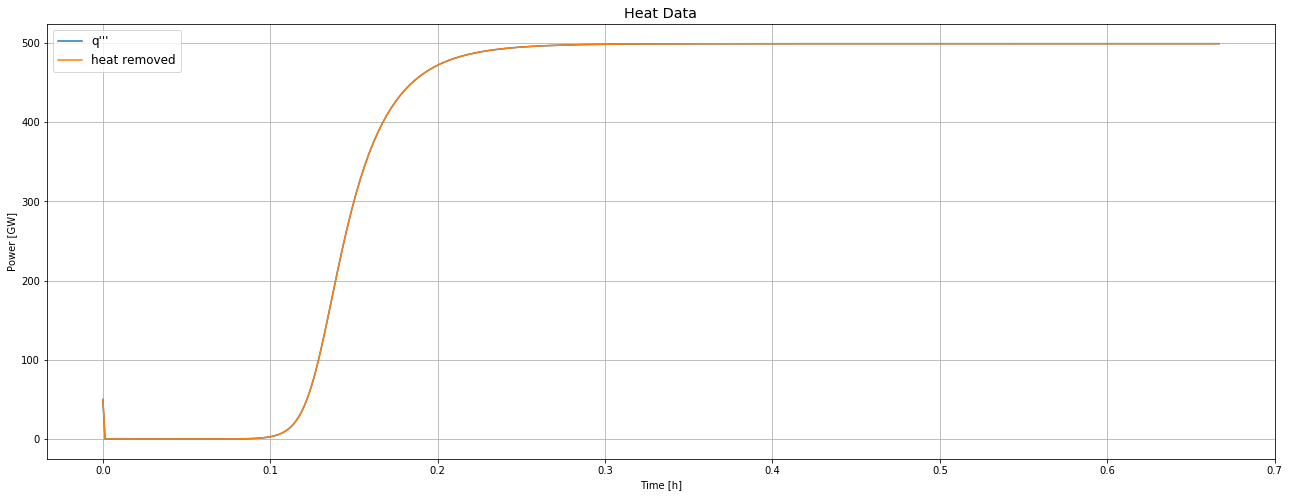

In [27]:
import matplotlib.pyplot as plt
heat_data = quantities1(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, heat_data["q''' [gW/m3]"], params['time_stamps']/3600, heat_data["heat removed [gW/m3]"])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Heat Data')
plt.legend(["q'''", "heat removed"])
plt.show()

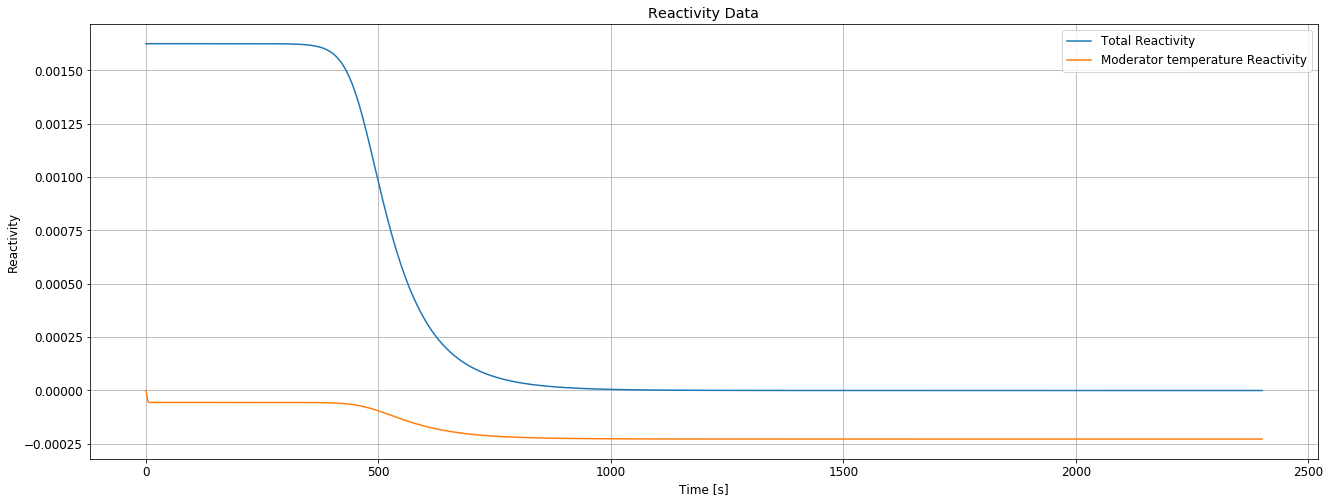

In [28]:
quants = quantities3(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps'], quants[0])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [s]')
plt.ylabel('Reactivity')
plt.title('Reactivity Data')
plt.legend(['Total Reactivity','Moderator temperature Reactivity'])
plt.show()


Text(0.5, 1.0, 'Regulating Rod Position')

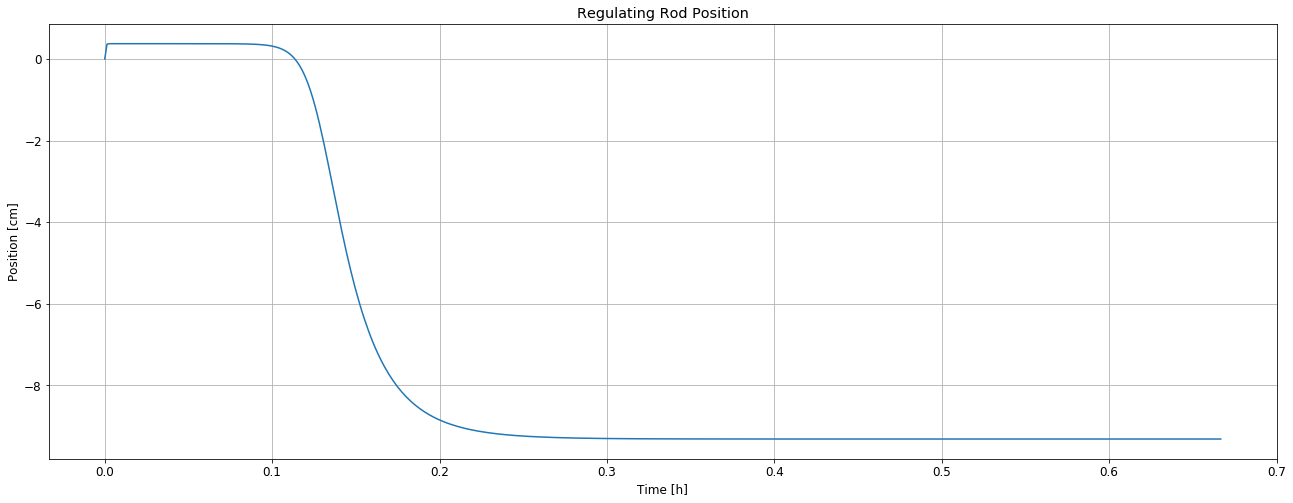

In [29]:
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, quants[1])
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Position [cm]')
plt.title('Regulating Rod Position')

Q''' and heat removed increase fairly quickly before reaching steady state in about 5-10 minutes. There is an initial spike in and then loss of heat removed as the neutron source is inserted and then quickly removed from the system, with heat removed staying mostly constant over this period of time.

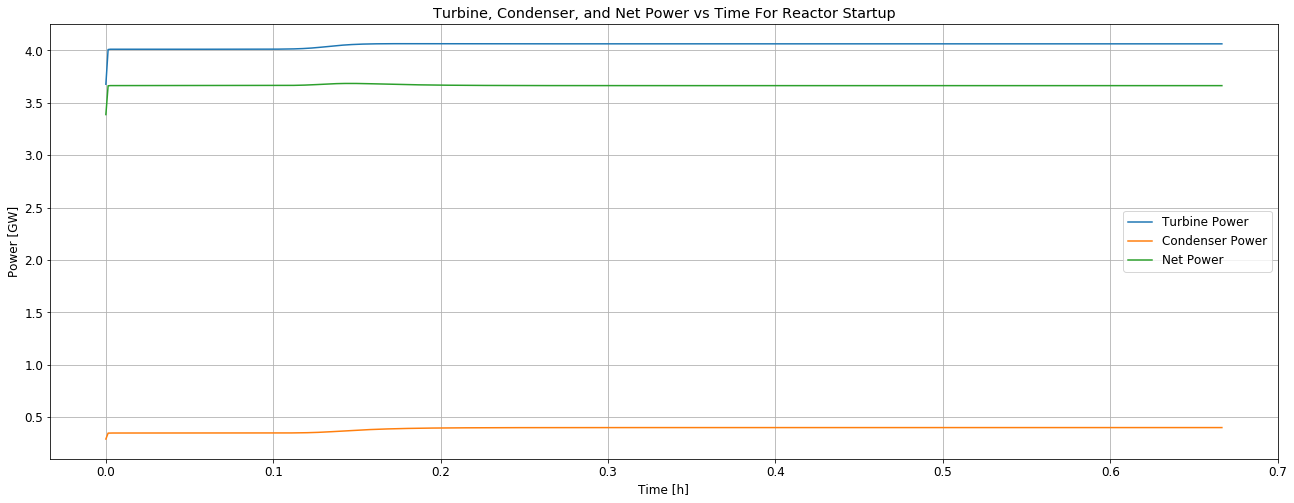

In [30]:
work_data = quantities2(u_vec_history, params, params['time_stamps'])
plt.figure(figsize=(22, 8))
plt.plot(params['time_stamps']/3600, work_data)
plt.grid()
plt.rc('font', size=12)
plt.xlabel('Time [h]')
plt.ylabel('Power [GW]')
plt.title('Turbine, Condenser, and Net Power vs Time For Reactor Startup')
plt.legend(['Turbine Power','Condenser Power', 'Net Power'])
plt.show()


Condenser work reaches its maximum at the beginning of startup and then decays over time, while turbine work starts at zero until it climbs to its maximum near the beginning of steady state operation, corresponding with turbine work becoming larger than condenser work with net work becoming positive around 0.5 gW. This change in work done corresponds with the second temperature jump after neutron source insertion and removal.

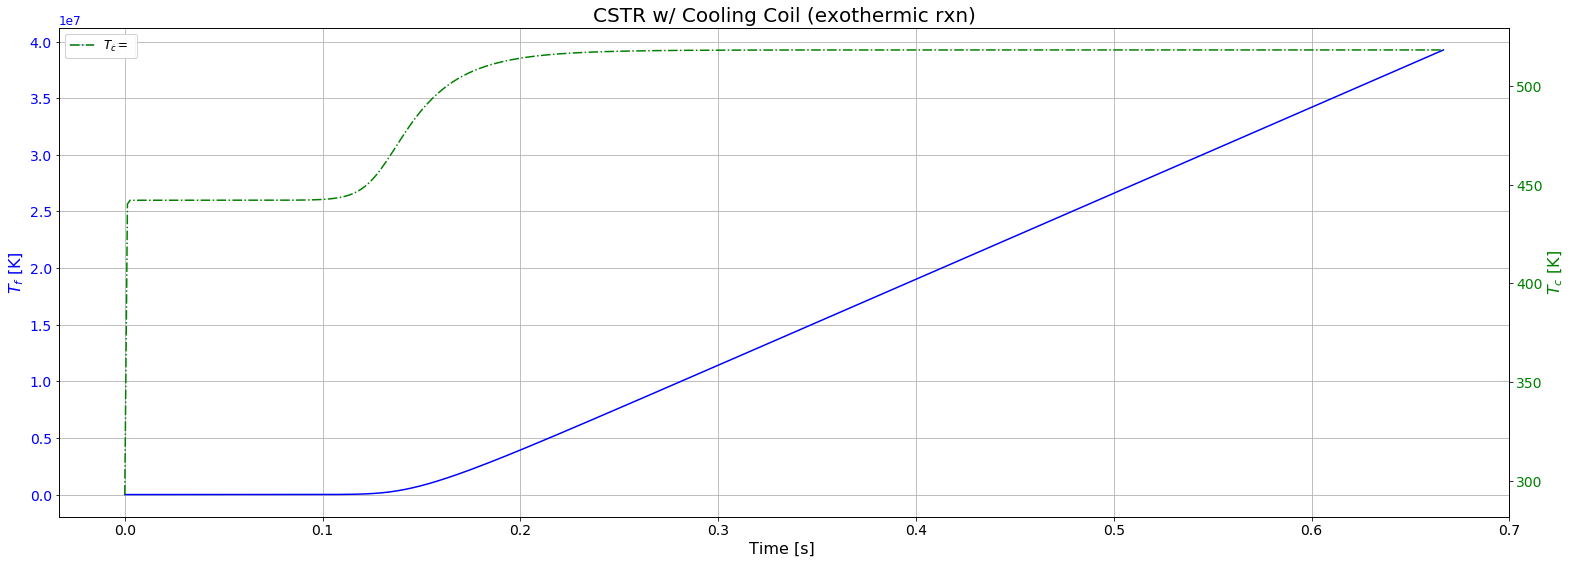

In [31]:
tmp()

Coolant and fuel temperatures spike heavily initially with the insertion and then removal of the initial neutron source. Two horizontal asymptotes can be observed in the temperature graphs. They can be explained as follows: after the initial neutron source insertion and removal, the two temperatures of the reactor go to an initial steady state condition where they are are seperated by approximately 50 K in temperature, with Q''' and heat removed being quite low as neutron density fails to increase. As neutron density begins to ramp up, so to do Q''', heat removed, and the temperatures of both the fuel and the coolant. This begins at around 400 seconds and continues until the reactor reaches steady state neutron density at around 800 seconds, closely mirroring the neutron density in this second region.